사용 장치: cuda
PyTorchGMM 클래스 정의 완료
MNIST 데이터 로드 완료. 형태: (60000, 784)

--- 실험 1: 고차원 픽셀 공간 GMM 클러스터링 시작 ---


Fitting GMM (K=10): 100%|██████████| 100/100 [00:15<00:00,  6.58it/s, log_likelihood=1256.4656]


Did not converge.


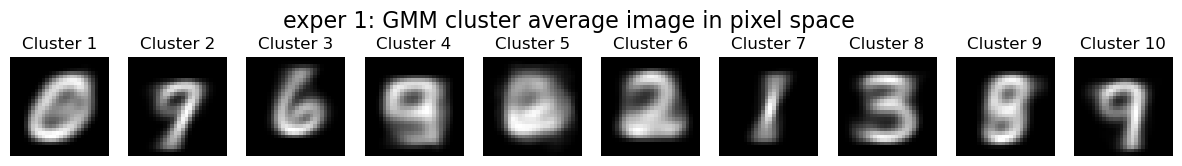

고차원 공간에서는 클러스터가 숫자의 형태를 명확하게 학습하지 못하고, 여러 숫자가 섞인 듯한 흐릿한 이미지를 생성합니다.


In [2]:
# === 1. 라이브러리 임포트 및 환경 설정 ===
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import trange
import warnings

# 경고 메시지 무시
warnings.filterwarnings("ignore")

# GPU 장치 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 장치: {DEVICE}")

# === 2. PyTorch GMM 클래스 정의 (GPU 연산용) ===
# (이전과 동일한 PyTorchGMM 클래스 코드가 여기에 위치합니다)
class PyTorchGMM:
    def __init__(self, n_components, max_iter=200, tol=1e-4, reg_covar=1e-6,
                 random_state=42, verbose=True, verbose_interval=10):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.reg_covar = reg_covar
        self.random_state = random_state
        self.verbose = verbose
        self.verbose_interval = verbose_interval
        self.device = DEVICE

        self.weights_ = None
        self.means_ = None
        self.covariances_ = None
        self.converged_ = False
        self.log_likelihood_ = -torch.inf

    def _initialize_parameters(self, X):
        if self.random_state:
            torch.manual_seed(self.random_state)

        n_samples, n_features = X.shape
        
        self.weights_ = torch.full((self.n_components,), 1.0 / self.n_components, device=self.device)
        
        indices = torch.randperm(n_samples)[:self.n_components]
        self.means_ = X[indices]
        
        self.covariances_ = torch.eye(n_features, device=self.device).unsqueeze(0).repeat(self.n_components, 1, 1)

    def _e_step(self, X):
        log_prob_norm_list = []
        for k in range(self.n_components):
            dist = torch.distributions.MultivariateNormal(
                self.means_[k], self.covariances_[k]
            )
            log_prob_norm_list.append(dist.log_prob(X))
        
        log_prob_matrix = torch.stack(log_prob_norm_list, dim=1)
        log_weighted_prob = log_prob_matrix + torch.log(self.weights_)
        
        log_prob_norm = torch.logsumexp(log_weighted_prob, dim=1)
        
        log_responsibilities = log_weighted_prob - log_prob_norm.unsqueeze(1)
        
        return torch.mean(log_prob_norm), log_responsibilities

    def _m_step(self, X, log_responsibilities):
        n_samples, n_features = X.shape
        responsibilities = torch.exp(log_responsibilities)
        
        nk = torch.sum(responsibilities, dim=0) + 1e-10 # 0으로 나누는 것을 방지
        self.weights_ = nk / n_samples
        
        self.means_ = torch.matmul(responsibilities.T, X) / nk.unsqueeze(1)
        
        for k in range(self.n_components):
            diff = X - self.means_[k]
            cov = torch.matmul((responsibilities[:, k] * diff.T), diff) / nk[k]
            # 대각선에 정규화 값을 더해 행렬을 안정화시킴
            cov.add_(torch.eye(n_features, device=self.device) * self.reg_covar)
            self.covariances_[k] = cov

    def fit(self, X):
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X).float()
        X = X.to(self.device)
        
        self._initialize_parameters(X)
        
        desc = f"Fitting GMM (K={self.n_components})"
        iterator = trange(self.max_iter, desc=desc) if self.verbose else range(self.max_iter)

        for i in iterator:
            prev_log_likelihood = self.log_likelihood_
            
            try:
                log_prob_norm, log_responsibilities = self._e_step(X)
            except ValueError as e:
                print(f"Error in E-step at iteration {i+1}: {e}")
                print("Covariance matrix likely became singular. Stopping training.")
                break
                
            self._m_step(X, log_responsibilities)
            
            self.log_likelihood_ = log_prob_norm
            
            if self.verbose and (i % self.verbose_interval == 0):
                iterator.set_postfix(log_likelihood=f"{self.log_likelihood_.item():.4f}")

            if i > 0 and torch.abs(self.log_likelihood_ - prev_log_likelihood) < self.tol:
                self.converged_ = True
                if self.verbose: print(f"Converged at iteration {i+1}.")
                break
        
        if not self.converged_ and self.verbose:
            print("Did not converge.")
            
    def predict(self, X):
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X).float()
        X = X.to(self.device)
        
        _, log_responsibilities = self._e_step(X)
        return torch.argmax(log_responsibilities, dim=1)

    def predict_proba(self, X):
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X).float()
        X = X.to(self.device)
        
        _, log_responsibilities = self._e_step(X)
        return torch.exp(log_responsibilities)

print("PyTorchGMM 클래스 정의 완료")


# === 3. MNIST 데이터 로드 및 전처리 ===
# (이전과 동일)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

X_mnist, y_mnist = next(iter(train_loader))
X_mnist, y_mnist = X_mnist.numpy(), y_mnist.numpy()

print(f"MNIST 데이터 로드 완료. 형태: {X_mnist.shape}")


# === 4. 실험 1: 고차원(784D) 픽셀 공간에서 GMM 클러스터링 ===
print("\n--- 실험 1: 고차원 픽셀 공간 GMM 클러스터링 시작 ---")

n_clusters_pixel = 10
# <<--- 수정된 부분: reg_covar 값을 1e-6에서 1e-4로 높여 수치적 안정성 확보
gmm_pixel = PyTorchGMM(n_components=n_clusters_pixel, max_iter=100, reg_covar=1e-4, random_state=42, verbose=True)
gmm_pixel.fit(X_mnist)

def visualize_cluster_means(gmm_model, title):
    fig, axes = plt.subplots(1, gmm_model.n_components, figsize=(15, 2))
    fig.suptitle(title, fontsize=16)
    for i, ax in enumerate(axes):
        if gmm_model.means_ is not None:
            mean_image = gmm_model.means_[i].cpu().numpy().reshape(28, 28)
            ax.imshow(mean_image, cmap='gray')
            ax.set_title(f"Cluster {i+1}")
        ax.axis('off')
    plt.show()

visualize_cluster_means(gmm_pixel, "exper 1: GMM cluster average image in pixel space ")
print("고차원 공간에서는 클러스터가 숫자의 형태를 명확하게 학습하지 못하고, 여러 숫자가 섞인 듯한 흐릿한 이미지를 생성합니다.")


--- 픽셀 공간 GMM에서 샘플링 시작 ---


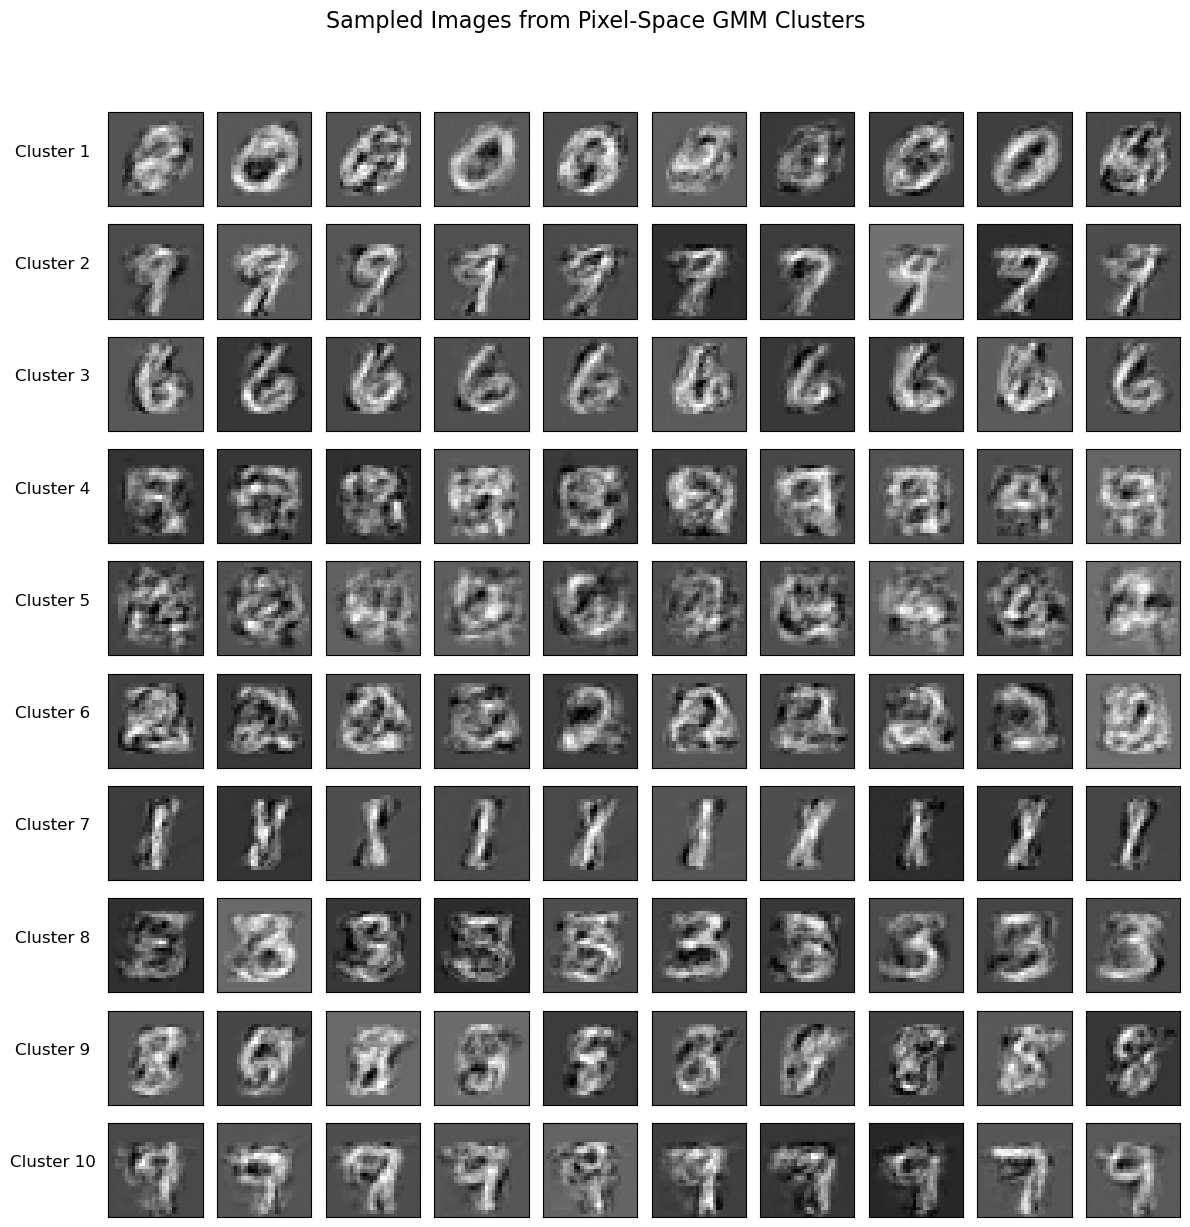

In [7]:
# === NEW: Sampling from Pixel-Space GMM Clusters ===

def sample_from_gmm_clusters(gmm_model, n_samples_per_cluster=10):
    """
    학습된 GMM의 각 클러스터에서 새로운 샘플을 생성합니다.
    """
    # 샘플을 저장할 딕셔너리
    sampled_images = {}
    
    # 모델 파라미터를 CPU로 이동 (분포 생성을 위해)
    means = gmm_model.means_.cpu()
    covariances = gmm_model.covariances_.cpu()
    
    with torch.no_grad():
        for k in range(gmm_model.n_components):
            # k번째 클러스터에 대한 다변수 정규분포 정의
            dist = torch.distributions.MultivariateNormal(
                loc=means[k],
                covariance_matrix=covariances[k]
            )
            # n개의 샘플 생성
            samples = dist.sample((n_samples_per_cluster,))
            sampled_images[k] = samples.numpy()
            
    return sampled_images

def visualize_sampled_images(sampled_data, n_samples, n_clusters):
    """
    샘플링된 이미지 데이터를 그리드 형태로 시각화합니다.
    """
    fig, axes = plt.subplots(n_clusters, n_samples, figsize=(n_samples * 1.2, n_clusters * 1.2))
    
    # Main Title
    fig.suptitle('Sampled Images from Pixel-Space GMM Clusters', fontsize=16, y=1.02)

    for k in range(n_clusters):
        # Row Title
        axes[k, 0].set_ylabel(f'Cluster {k+1}', rotation=0, size='large', labelpad=40)
        
        for i in range(n_samples):
            ax = axes[k, i]
            image = sampled_data[k][i].reshape(28, 28)
            ax.imshow(image, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to make space for suptitle
    plt.show()

# --- 실행 로직 ---
print("\n--- 픽셀 공간 GMM에서 샘플링 시작 ---")

# gmm_pixel 모델이 학습 완료된 상태여야 합니다.
if gmm_pixel.converged_ or gmm_pixel.log_likelihood_ != -torch.inf:
    # 각 클러스터에서 10개의 샘플 생성
    n_to_sample = 10
    sampled_data_pixel = sample_from_gmm_clusters(gmm_pixel, n_samples_per_cluster=n_to_sample)

    # 샘플링된 이미지 시각화
    visualize_sampled_images(sampled_data_pixel, n_samples=n_to_sample, n_clusters=gmm_pixel.n_components)
else:
    print("GMM model for pixel space did not train successfully. Skipping sampling.")

여러 숫자가 겹쳐진 듯한 노이즈 낀 이미지나 추상적인 패턴이 보임.

784차원의 고차원 픽셀 공간에서 학습된 GMM 클러스터들이 하나의 숫자 카테고리를 명확하게 학습하지 못하고, 단순히 픽셀 분포가 유사한 여러 숫자 이미지를 어설프게 평균 낸 상태라고 생각이 듦.

그럼 고차원 공간에서 True데이터와 비슷한 데이터를 샘플링하기 위해서는?

정답 데이터와 비슷한 이미지를 생성하려면, **데이터의 진짜 구조를 성공적으로 학습한 '품질 좋은 모델'** 에서 샘플링해야 함.

오토인코더로 mnist데이터의 특징 공간 학습

In [8]:
# === 5. 오토인코더 모델 정의 및 훈련 (차원 축소용) ===
# (이전과 동일)
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

print("\n--- 오토인코더 훈련 시작 (차원 축소) ---")
latent_dim = 32
autoencoder = Autoencoder(latent_dim=latent_dim).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
epochs = 20

train_loader_ae = DataLoader(train_dataset, batch_size=256, shuffle=True)

for epoch in range(epochs):
    for data, _ in train_loader_ae:
        data = data.to(DEVICE)
        _, decoded = autoencoder(data)
        loss = criterion(decoded, data)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

with torch.no_grad():
    X_mnist_torch = torch.from_numpy(X_mnist).float().to(DEVICE)
    X_latent, _ = autoencoder(X_mnist_torch)
    X_latent = X_latent.cpu().numpy()

print(f"오토인코더 훈련 완료. 잠재 공간 데이터 생성: {X_latent.shape}")


--- 오토인코더 훈련 시작 (차원 축소) ---
Epoch 1/20, Loss: 0.4743
Epoch 2/20, Loss: 0.4372
Epoch 3/20, Loss: 0.4212
Epoch 4/20, Loss: 0.4150
Epoch 5/20, Loss: 0.3998
Epoch 6/20, Loss: 0.3943
Epoch 7/20, Loss: 0.3699
Epoch 8/20, Loss: 0.3977
Epoch 9/20, Loss: 0.3917
Epoch 10/20, Loss: 0.3672
Epoch 11/20, Loss: 0.3531
Epoch 12/20, Loss: 0.3915
Epoch 13/20, Loss: 0.3788
Epoch 14/20, Loss: 0.3613
Epoch 15/20, Loss: 0.3666
Epoch 16/20, Loss: 0.3496
Epoch 17/20, Loss: 0.3895
Epoch 18/20, Loss: 0.3694
Epoch 19/20, Loss: 0.3703
Epoch 20/20, Loss: 0.3617
오토인코더 훈련 완료. 잠재 공간 데이터 생성: (60000, 32)



--- 실험 2: 잠재 공간 GMM 클러스터링 시작 ---


Fitting GMM (K=10):  87%|████████▋ | 87/100 [00:00<00:00, 98.87it/s, log_likelihood=-54.1520] 


Converged at iteration 88.


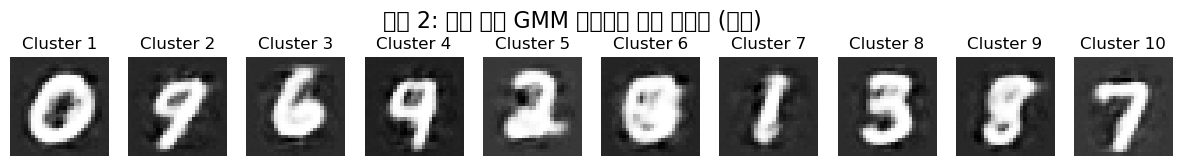

잠재 공간에서 클러스터링하면 각 클러스터의 평균이 특정 숫자를 명확하게 나타내는 것을 볼 수 있습니다.

--- t-SNE 시각화 생성 중 (시간이 소요될 수 있습니다) ---


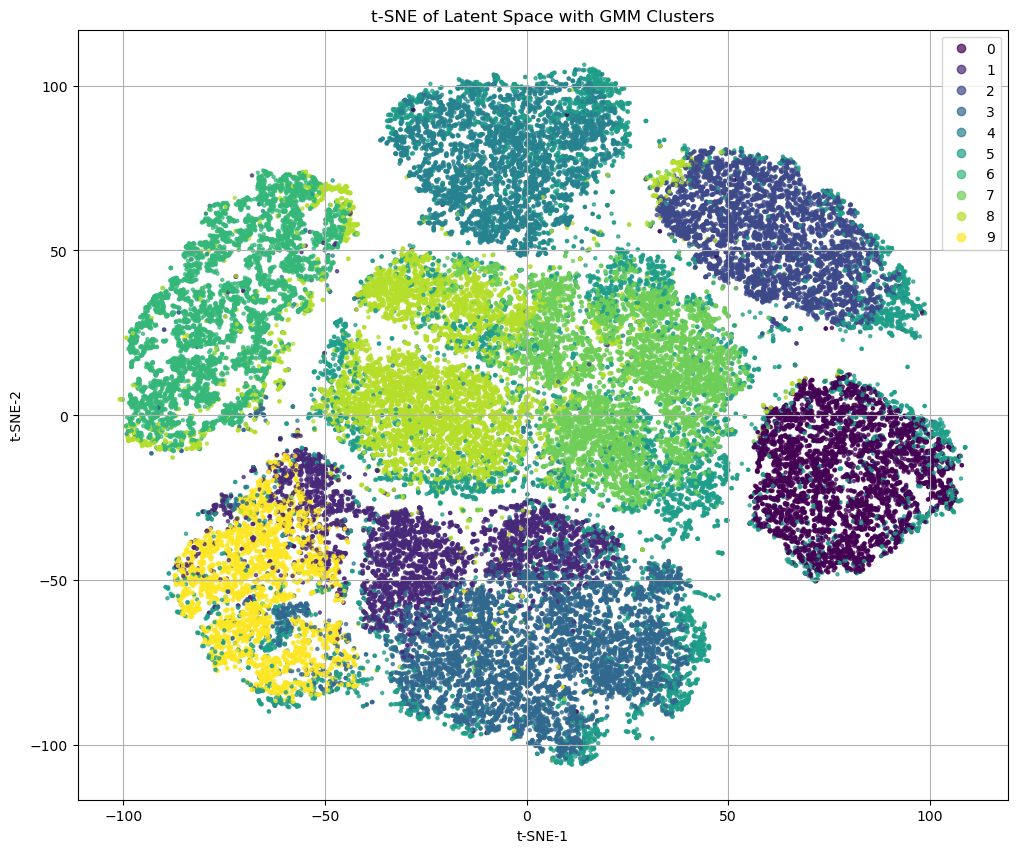

In [9]:
# === 6. 실험 2: 잠재 공간(32D)에서 GMM 클러스터링 ===
print("\n--- 실험 2: 잠재 공간 GMM 클러스터링 시작 ---")
n_clusters_latent = 10
# 잠재 공간은 차원이 낮아 기본 reg_covar 값으로도 안정적입니다.
gmm_latent = PyTorchGMM(n_components=n_clusters_latent, max_iter=100, random_state=42, verbose=True)
gmm_latent.fit(X_latent)

def visualize_latent_cluster_means(gmm_model, decoder, title):
    fig, axes = plt.subplots(1, gmm_model.n_components, figsize=(15, 2))
    fig.suptitle(title, fontsize=16)
    with torch.no_grad():
        for i, ax in enumerate(axes):
             if gmm_model.means_ is not None:
                latent_mean = gmm_model.means_[i].unsqueeze(0)
                decoded_image = decoder(latent_mean).cpu().numpy().reshape(28, 28)
                ax.imshow(decoded_image, cmap='gray')
                ax.set_title(f"Cluster {i+1}")
             ax.axis('off')
    plt.show()

visualize_latent_cluster_means(gmm_latent, autoencoder.decoder, "실험 2: 잠재 공간 GMM 클러스터 평균 이미지 (복원)")
print("잠재 공간에서 클러스터링하면 각 클러스터의 평균이 특정 숫자를 명확하게 나타내는 것을 볼 수 있습니다.")

print("\n--- t-SNE 시각화 생성 중 (시간이 소요될 수 있습니다) ---")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_latent)

labels_latent = gmm_latent.predict(X_latent).cpu().numpy()

plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_latent, cmap='viridis', s=5, alpha=0.7)
plt.title('t-SNE of Latent Space with GMM Clusters')
plt.xlabel('t-SNE-1')
plt.ylabel('t-SNE-2')
plt.legend(handles=scatter.legend_elements()[0], labels=range(n_clusters_latent))
plt.grid(True)
plt.show()


--- 잠재 공간 GMM에서 고품질 샘플링 시작 ---


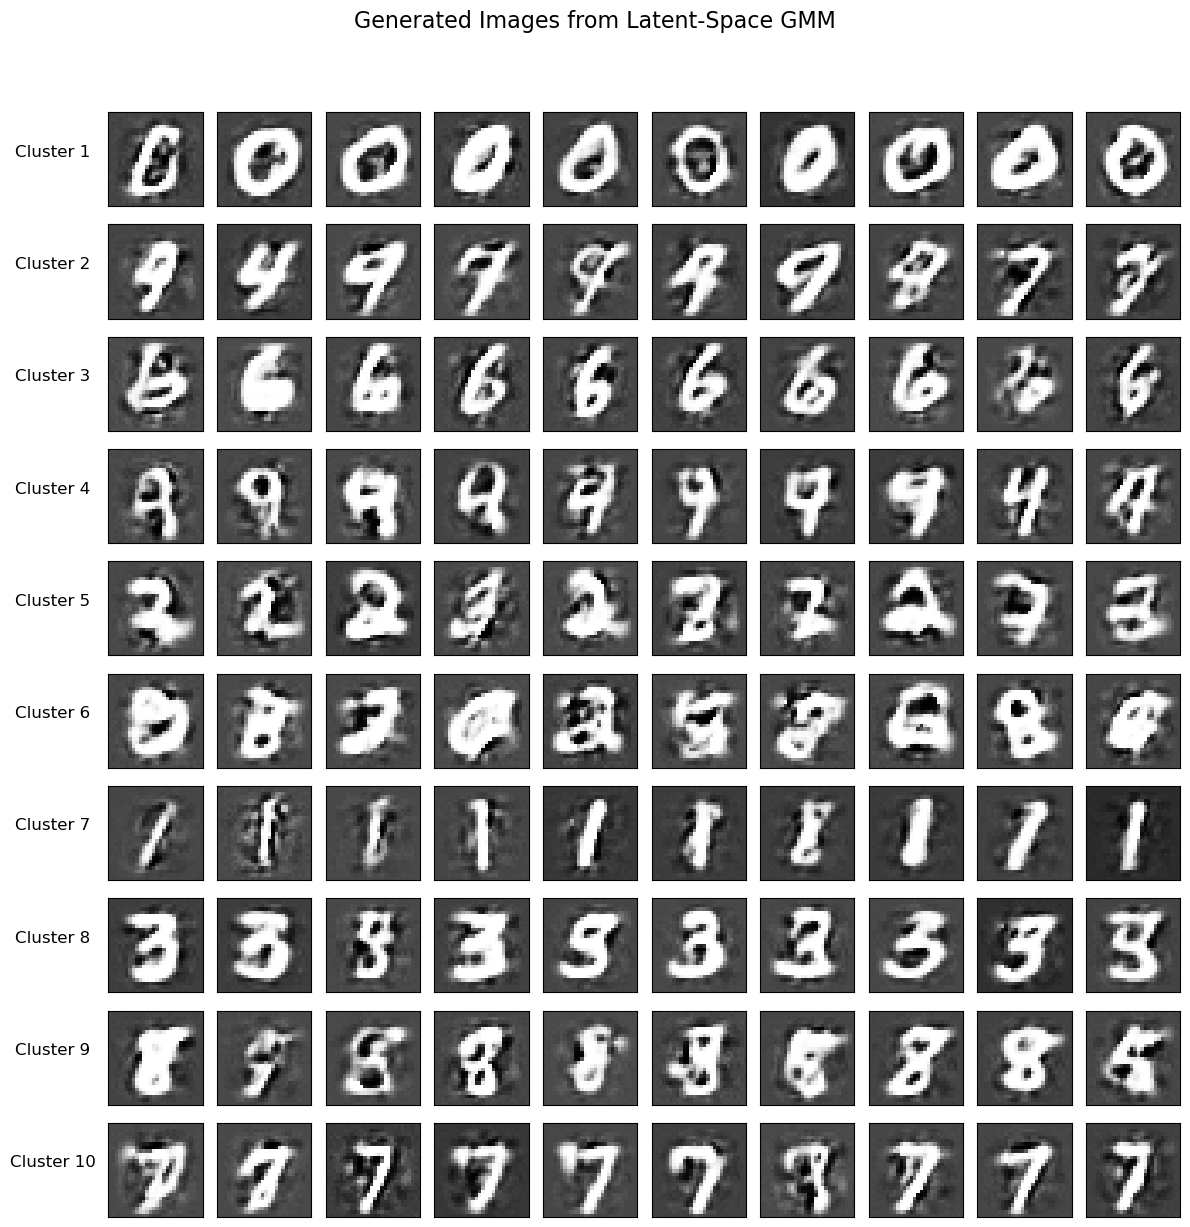

In [10]:
# === NEW: High-Quality Sampling from Latent-Space GMM Clusters ===

def sample_and_decode_from_gmm(gmm_model, decoder, n_samples_per_cluster=10):
    """
    잠재 공간 GMM에서 샘플링한 후 디코더로 이미지로 복원합니다.
    """
    sampled_images = {}
    
    # 모델 파라미터를 CPU로 이동
    means = gmm_model.means_.cpu()
    covariances = gmm_model.covariances_.cpu()
    
    decoder.cpu() # 디코더도 CPU에서 사용
    
    with torch.no_grad():
        for k in range(gmm_model.n_components):
            # 잠재 공간에서 k번째 클러스터의 분포 정의
            dist = torch.distributions.MultivariateNormal(
                loc=means[k],
                covariance_matrix=covariances[k]
            )
            # 잠재 벡터 샘플링
            latent_samples = dist.sample((n_samples_per_cluster,))
            
            # 디코더를 통해 이미지로 복원
            decoded_samples = decoder(latent_samples)
            sampled_images[k] = decoded_samples.numpy()
            
    return sampled_images

def visualize_decoded_images(sampled_data, n_samples, n_clusters):
    """
    복원된(생성된) 이미지 데이터를 그리드 형태로 시각화합니다.
    """
    fig, axes = plt.subplots(n_clusters, n_samples, figsize=(n_samples * 1.2, n_clusters * 1.2))
    
    # Main Title
    fig.suptitle('Generated Images from Latent-Space GMM', fontsize=16, y=1.02)

    for k in range(n_clusters):
        # Row Title
        axes[k, 0].set_ylabel(f'Cluster {k+1}', rotation=0, size='large', labelpad=40)
        
        for i in range(n_samples):
            ax = axes[k, i]
            image = sampled_data[k][i].reshape(28, 28)
            ax.imshow(image, cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout for suptitle
    plt.show()

# --- 실행 로직 ---
print("\n--- 잠재 공간 GMM에서 고품질 샘플링 시작 ---")

# gmm_latent 모델과 autoencoder가 학습 완료된 상태여야 합니다.
if gmm_latent.converged_ or gmm_latent.log_likelihood_ != -torch.inf:
    # 각 클러스터에서 10개의 샘플 생성
    n_to_sample = 10
    generated_data = sample_and_decode_from_gmm(
        gmm_latent, 
        autoencoder.decoder, 
        n_samples_per_cluster=n_to_sample
    )

    # 생성된 이미지 시각화
    visualize_decoded_images(generated_data, n_samples=n_to_sample, n_clusters=gmm_latent.n_components)
else:
    print("GMM model for latent space did not train successfully. Skipping sampling.")